In [31]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow import keras, one_hot

import matplotlib.pyplot as plt

In [34]:
IMAGE_SIZE = [224,224]
BATCH_SIZE = 64
NUM_CLASSES = 4
DROUPOUT_RATE = 0.3
DIRECTORY_TRAIN = "/content/train.zip"
DIRECTORY_TEST = "/content/test.zip"

In [35]:
import zipfile
import os
import tensorflow as tf

# Assuming your zip file is located at /content/train.zip
zip_file_path = '/content/train.zip'
extract_dir = '/content/train'  # Directory where you want to extract the images

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Now, set DIRECTORY_TRAIN to the extracted directory
DIRECTORY_TRAIN = extract_dir
IMAGE_SIZE = [224, 224]  # Example image size
BATCH_SIZE = 64  # Example batch size

# Load your dataset
train = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTORY_TRAIN,
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTORY_TRAIN,
    validation_split=0.2,
    subset="validation",
    seed=1,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


Found 10242 files belonging to 2 classes.
Using 8194 files for training.
Found 10242 files belonging to 2 classes.
Using 2048 files for validation.


In [36]:
train.class_names

['__MACOSX', 'train']

In [37]:
# List the contents of the extracted directory
extracted_contents = os.listdir(extract_dir)
print("Extracted contents:", extracted_contents)


Extracted contents: ['train', '__MACOSX']


In [38]:
# Set DIRECTORY_TRAIN to the 'train' subdirectory
DIRECTORY_TRAIN = os.path.join(extract_dir, 'train')
IMAGE_SIZE = [224, 224]  # Example image size
BATCH_SIZE = 64  # Example batch size

# Check the structure inside DIRECTORY_TRAIN
print("Classes found in DIRECTORY_TRAIN:", os.listdir(DIRECTORY_TRAIN))

# Load your dataset
train = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTORY_TRAIN,
    validation_split=0.2,
    subset="training",
    seed=1,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

validation = tf.keras.preprocessing.image_dataset_from_directory(
    DIRECTORY_TRAIN,
    validation_split=0.2,
    subset="validation",
    seed=1,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)


Classes found in DIRECTORY_TRAIN: ['VeryMildDemented', 'ModerateDemented', 'NonDemented', 'MildDemented']
Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


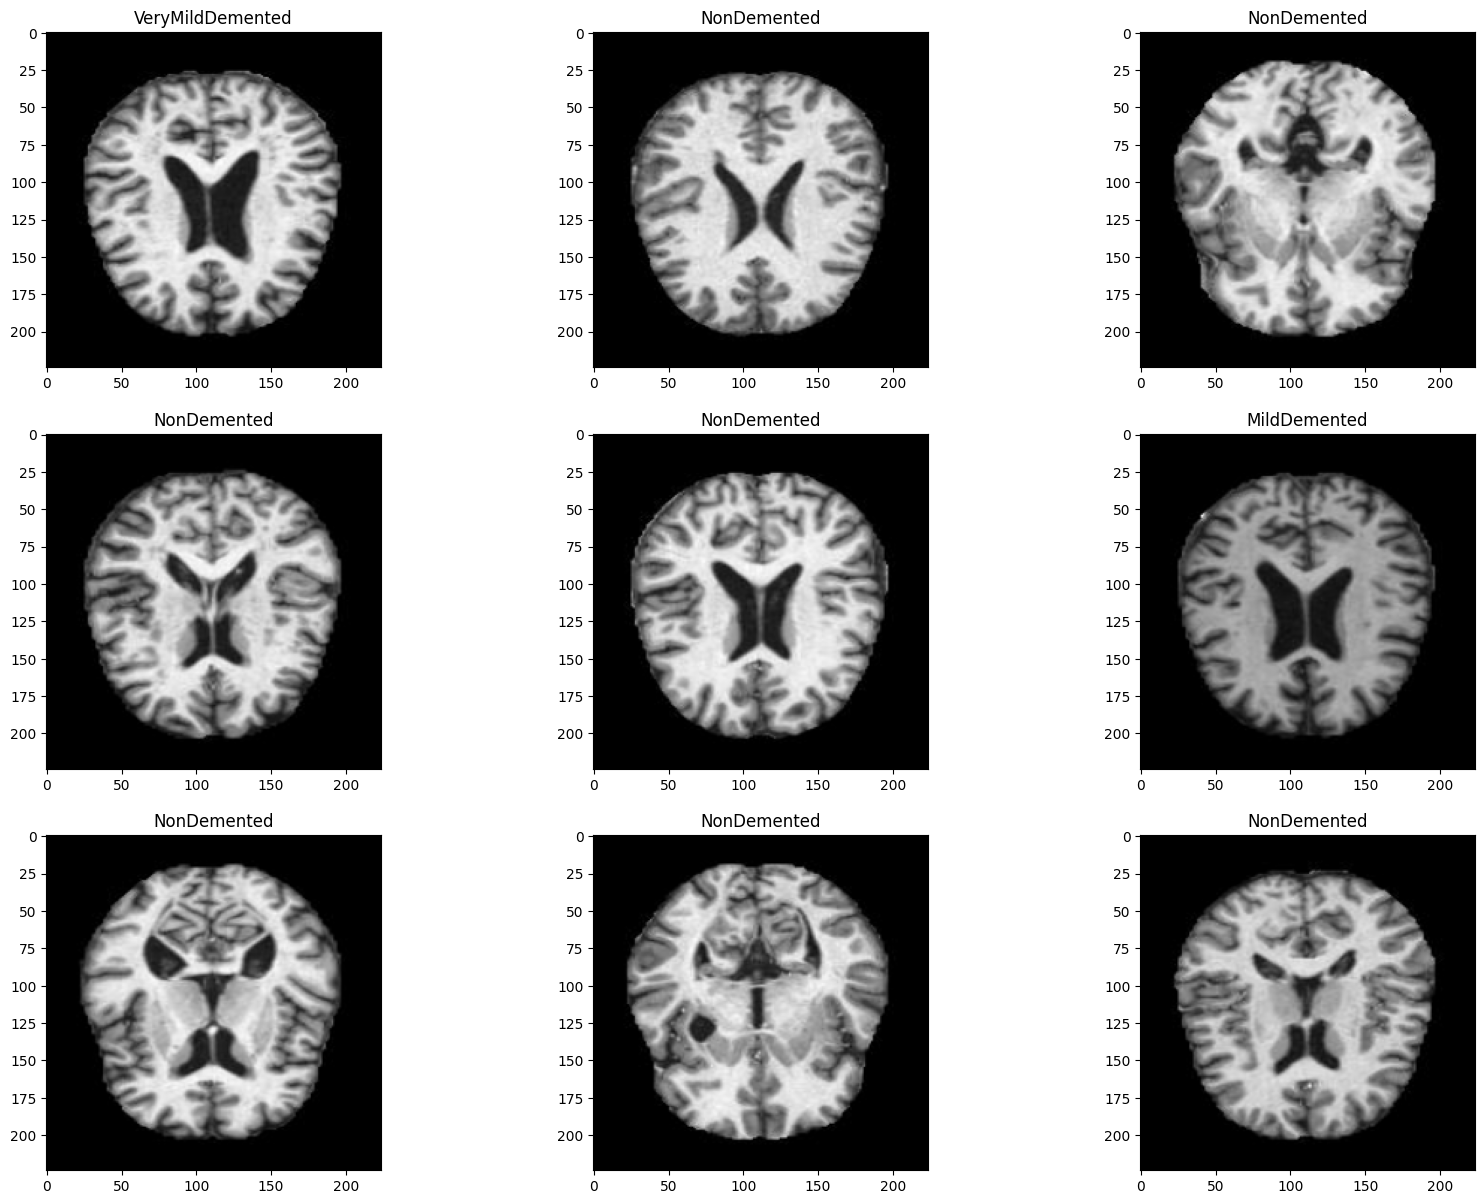

In [39]:
batch = train.take(1)

plt.figure(figsize=(20,20))
for images in batch:
    for i in range(9):
        plt.subplot(4, 3, i + 1)
        image = images[0][i]
        label = images[1][i]
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(train.class_names[label])

In [40]:
label_occurency = {0: 0, 1: 0, 2: 0, 3: 0}
for batch in train:
    label_occurency[0] += (batch[1].numpy() == 0).sum()
    label_occurency[1] += (batch[1].numpy() == 1).sum()
    label_occurency[2] += (batch[1].numpy() == 2).sum()
    label_occurency[3] += (batch[1].numpy() == 3).sum()
#     print(batch[1].numpy())
print(label_occurency)

{0: 578, 1: 39, 2: 2053, 3: 1427}


In [41]:
def one_hot_label(image, label):
    label = one_hot(label, NUM_CLASSES)
    return image, label

In [42]:
train = train.map(one_hot_label)
validation = validation.map(one_hot_label)

In [43]:
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]



model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*IMAGE_SIZE, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(DROUPOUT_RATE),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(DROUPOUT_RATE),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(NUM_CLASSES, 'softmax')
])

model.compile(optimizer='adam',
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                   

In [45]:
epochs=15
history = model.fit(
  train,
  validation_data=validation,
  epochs=epochs
)

Epoch 1/15
65/65 [==============================] - 297s 5s/step - loss: 0.7883 - accuracy: 0.8262 - precision: 0.6995 - recall: 0.5340 - auc: 0.8861 - val_loss: 0.7808 - val_accuracy: 0.8457 - val_precision: 0.8755 - val_recall: 0.4463 - val_auc: 0.9184
Epoch 2/15
65/65 [==============================] - 297s 5s/step - loss: 0.6908 - accuracy: 0.8546 - precision: 0.7508 - recall: 0.6266 - auc: 0.9143 - val_loss: 0.6919 - val_accuracy: 0.8562 - val_precision: 0.7858 - val_recall: 0.5840 - val_auc: 0.9196
Epoch 3/15
65/65 [==============================] - 297s 5s/step - loss: 0.5810 - accuracy: 0.8808 - precision: 0.7922 - recall: 0.7091 - auc: 0.9394 - val_loss: 0.6450 - val_accuracy: 0.8704 - val_precision: 0.7952 - val_recall: 0.6484 - val_auc: 0.9329
Epoch 4/15
65/65 [==============================] - 294s 5s/step - loss: 0.5418 - accuracy: 0.8865 - precision: 0.7995 - recall: 0.7288 - auc: 0.9470 - val_loss: 0.6867 - val_accuracy: 0.8357 - val_precision: 0.6834 - val_recall: 0.638

In [54]:
def plot_metric(metric, history):
    fig = plt.figure(figsize=(4,2))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history[metric])
    ax.plot(history.history['val_' + metric])
    ax.set_title(f'CNN Model {metric}')
    ax.legend(['train', "validation"])
    ax.set_xlabel("epochs")
    ax.set_ylabel(metric)

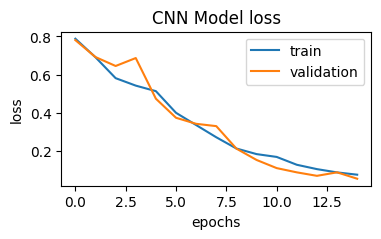

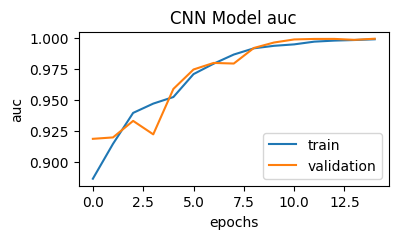

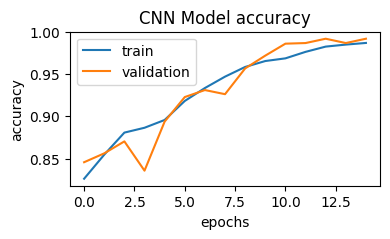

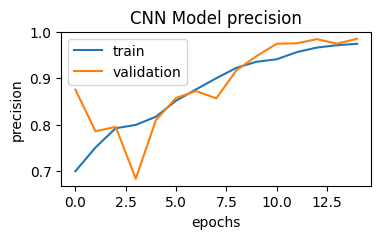

In [55]:
plot_metric('loss', history)
plot_metric('auc', history)
plot_metric('accuracy', history)
plot_metric('precision', history)